/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'clf__NB__var_smoothing': 1.776925089731948e-11, 'clf__RF__max_depth': 26, 'clf__RF__min_samples_leaf': 5, 'clf__RF__min_samples_split': 7, 'clf__RF__n_estimators': 524, 'clf__SVM__C': 0.0005528366765153171, 'clf__SVM__gamma': 278.5476110530462, 'sel__n_components': 3}
train 정확도: 0.7200
test 정확도: 0.4286
total 정확도: 0.6562
others 정확도: 0.2857
[[5 0 1 0]
 [1 1 0 0]
 [1 1 3 3]
 [0 0 0 9]]
[[1 0 0 0]
 [0 0 0 1]
 [0 0 0 2]
 [0 0 1 2]]
[[ 6  0  1  0]
 [ 1  1  0  1]
 [ 1  1  3  5]
 [ 0  0  1 11]]
[[12  0 14 16]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


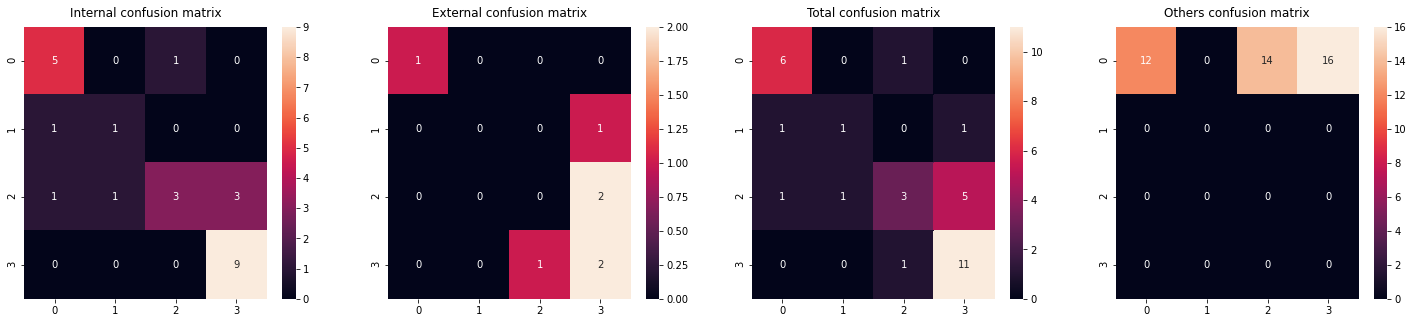

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         2
         3.0       0.40      0.67      0.50         3

    accuracy                           0.43         7
   macro avg       0.35      0.42      0.38         7
weighted avg       0.31      0.43      0.36         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#SVM, RF, NB 묶어서 시도

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, MaxAbsScaler,  QuantileTransformer
from tensorflow.python.keras.utils import np_utils
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN

seed=0
np.random.seed(seed)

#데이터 입력
df = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/MORDRED(2D)/VRK2_mordred(2D)_apppendscore_dropsmiles_30feat.csv')
data = pd.read_csv('/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/MORDRED(2D)/VRK2Others_morgan_2D_apppendscore_dropsmiles_30feat.csv')

#데이터 분류
dataset = df.values
X = dataset[:,0:-1]
Y = dataset[:,-1]

data = data.values
X_others =data[:,0:-1]
Y_others =data[:,-1]

#복합샘플링

randomover = RandomOverSampler(random_state=seed)
X_re, Y_re = randomover.fit_resample(X, Y)

#ada = ADASYN(random_state=seed)
#X_re, Y_re = ada.fit_resample(X_re, Y_re)

#smote = SMOTE(random_state=seed)
#X_re, Y_re = smote.fit_resample(X_re, Y_re)

#smoteenn = SMOTEENN(random_state=seed)
#X_re, Y_re = smoteenn.fit_resample(X_re, Y_re)

#X 표준화

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_others_scaled = scaler.transform(X_others)

#학습셋과 테스트셋을 나눔

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=seed)

#차원 줄이기

pca = PCA()

#VotingClassifier 사용

clf = VotingClassifier(estimators=[('SVM', SVC(probability=True)),('NB', GaussianNB()), ('RF', RandomForestClassifier())], voting='soft')

#pipeline구축

step = [('sel',pca), ('clf', clf) ]
pipeline = Pipeline(step)

#파라미터 튜닝

parameter = [{'sel__n_components':list(range(2,20)), 'clf__SVM__C':loguniform(1e-5,1), 'clf__SVM__gamma':loguniform(1,1e3),'clf__NB__var_smoothing':loguniform(1e-20, 1e-10),
             'clf__RF__n_estimators':list(range(100, 1000)), 'clf__RF__max_depth':list(range(2,100)), 
             'clf__RF__min_samples_leaf':list(range(2,20)), 'clf__RF__min_samples_split':list(range(2,50))}]
grid = RandomizedSearchCV(pipeline, parameter, n_iter=1000, cv=5, scoring = 'accuracy', n_jobs = -1, random_state=seed)
grid.fit(X_train, Y_train)

#성능 측정

pred_train = grid.predict(X_train)
pred_test = grid.predict(X_test)
pred_total = grid.predict(X_scaled)
pred_others = grid.predict(X_others_scaled)
accuracy = accuracy_score(Y_train, pred_train)
ex_accuracy = accuracy_score(Y_test, pred_test)
tot_accuracy = accuracy_score(Y, pred_total)
others_accuracy = accuracy_score(Y_others, pred_others)

print(grid.best_params_)

print('train 정확도: {0:.4f}'.format(accuracy))
print('test 정확도: {0:.4f}'.format(ex_accuracy))
print('total 정확도: {0:.4f}'.format(tot_accuracy))
print('others 정확도: {0:.4f}'.format(others_accuracy))

conf = confusion_matrix(Y_train, pred_train, labels=[0,1,2,3])
exconf = confusion_matrix(Y_test, pred_test, labels=[0,1,2,3])
totconf = confusion_matrix(Y, pred_total, labels=[0,1,2,3])
othersconf = confusion_matrix(Y_others, pred_others, labels=[0,1,2,3])

print(conf)
print(exconf)
print(totconf)
print(othersconf)  

#모델 저장 

model = grid.best_estimator_

saved_model = joblib.dump(model,'/content/drive/MyDrive/Inhibitor classification/Inhibitor/VRK2/VRK2_ensemble_0423_2.pkl')

#standard scaling만:0.5(MinMax도) Normalizer만:0.6(0.5, 0.6, 0.53) Binarizer만: 0.4 RobustScaler만:0.65 스케일링은 RobustScaler로

#0331: Robust만 시행 0331_2: Robust, kernel='linear', C=1 0331_3: Robust, kernal rbf, C=36, gamma=202 0.91 0.45 0.83 0331_4: Robust, kernal rbf, C=0.509, gamma=880 random_state=52, pca component 3 0.50 0.65 0.53

#0401_1 0.91 0.45 0.83

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(25, 5))
sns.heatmap(conf, annot=True, ax=ax[0])
ax[0].set_title('Internal confusion matrix', pad = 10)
sns.heatmap(exconf, annot=True, ax=ax[1])
ax[1].set_title('External confusion matrix', pad = 10)
sns.heatmap(totconf, annot=True, ax=ax[2])
ax[2].set_title('Total confusion matrix', pad = 10)
sns.heatmap(othersconf, annot=True, ax=ax[3])
ax[3].set_title('Others confusion matrix', pad = 10)

plt.show()

#Classification report

print(classification_report(Y_test, pred_test))